In [5]:
using Flux, DiffEqFlux, Plots, DifferentialEquations, Random, Optim, Interact
Random.seed!(1);

MethodError: MethodError: no method matching add(; path="/home/julius/Documents/julia_env/Project.toml")
Closest candidates are:
  add(!Matched::Pkg.Types.Context, !Matched::Array{Pkg.Types.PackageSpec,1}; strict, platform, kwargs...) at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.3/Pkg/src/API.jl:72
  add(!Matched::Array{Pkg.Types.PackageSpec,1}; kwargs...) at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.3/Pkg/src/API.jl:69
  add(!Matched::Union{AbstractString, Pkg.Types.PackageSpec}; kwargs...) at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.3/Pkg/src/API.jl:66
  ...

# Neural Differential Equations in Julia
> Exploring the [Flux.jl](https://github.com/FluxML/Flux.jl) and [DiffEqFlux.jl](https://github.com/JuliaDiffEq/DiffEqFlux.jl) packages. 


## Warm-Up: Using Flux for Linear Regression

[Flux](https://julialang.org/blog/2018/12/ml-language-compiler/): "...typical frameworks are all-encompassing monoliths in hundreds of thousands of lines of C++, Flux is only a thousand lines of straightforward Julia code. Simply take one package for gradients (Zygote.jl), one package for GPU support (CuArrays.jl), sprinkle with some light convenience functions, bake for fifteen minutes and out pops a fully-featured ML stack."

**Problem:** Given data $(x_i,y_i)_{i=0}^m$ we want to approximately solve the problem 

$$ \min_{W,b} \sum_{i=0}^m \| W*x_i+b - y_i \|_2^2. $$

11.6764266288668


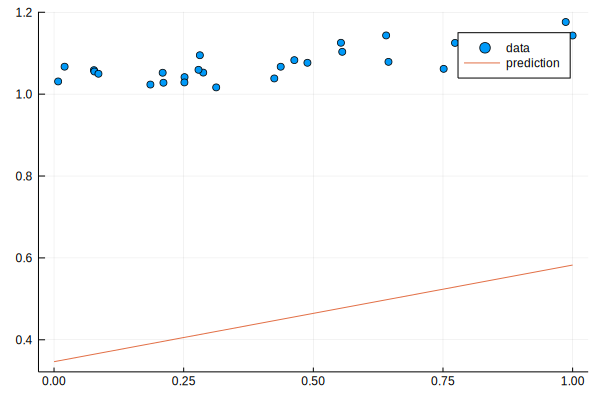

In [2]:
# model
W = rand(1)
b = rand(1)

# prediction
pred(x) = W.*x .+ b

# loss
loss(x, y) = sum(abs2, (y .- pred(x)))

# data
samples = 30
noise = 0.1

x = rand(samples)
y = rand(1).*x .+ rand(1) .+ noise.*rand(samples) 

# initial loss
println(loss(x, y))

# plot
scatter(x, y, label="data")
dx = range(0, 1; length=100)
# Note: mutating/in-place functions have names that end in !
plot!(dx, pred(dx), label="prediction")

**Idea:** To improve the prediction we can take the gradients of W and b with respect to the loss and perform gradient descent.

In contrast to TensorFlow or PyTorch in Python this is possible without tracing the operations in advance (Julia is just-in-time compiled, the *computational graph* is Julia’s own syntax).

Step: 20 Loss: 0.08382468595736174
Step: 40 Loss: 0.029932716973369647
Step: 60 Loss: 0.021570862561361294
Step: 80 Loss: 0.02027344087635299
Step: 100 Loss: 0.020072133493350422


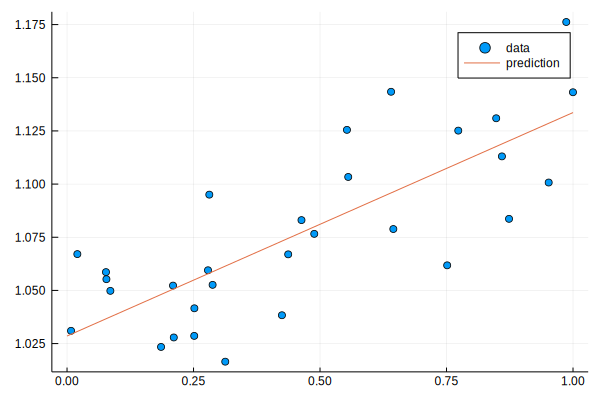

In [3]:
# gradient steps
steps = 100
# learning rate
lr = 0.01

# gradient descent
for i=1:steps
  gs = gradient(() -> loss(x, y), params(W, b))
  W .-= lr .* gs[W]
  b .-= lr .* gs[b]
  if i%20==0
    println("Step: $i Loss: $(loss(x, y))")
  end
end

# plot
scatter(x, y, label="data")
dx = range(0, 1; length=100)
plot!(dx, pred(dx), label="prediction")

## Neural Differential Equations using DiffEqFlux

[DiffEqFlux](https://julialang.org/blog/2019/01/fluxdiffeq/): "Layers have traditionally been simple functions like matrix multiply, but in the spirit of differentiable programming people are increasingly experimenting with much more complex functions, such as ray tracers and physics engines. Turns out that differential equations solvers fit this framework, too."


**Problem:** Given data $(t_i, u(t_i))_{i=0}^m$ of the solution to an *unkown* ODE

$$ u'(t) = f(u), \quad u(t_0) = u_0 $$

**Goal:**  Train a neural network model $\mathcal{N}_\Phi$ (with learnable parameters $\Phi$) to approximately recover $f$, i.e. learn the underlying ODE from data.

**Idea:** Numerically solve the *neural* ODE 

$$ \tilde{u}_\Phi'(t) = \mathcal{N}_{\Phi}(\tilde{u}_\Phi), \quad \tilde{u}_\Phi(t_0) = u_0 $$

at times $(t_i)_{i=0}^t$ with a package that allows computing the gradient of the error 
$$\sum_{i=0}^m \big( \tilde{u}_\Phi(t_i)-u(t_i)\big)^2$$

w.r.t. to $\Phi$ in order to perform first-order optimization. 

### Underlying (Unkown) Dynamics

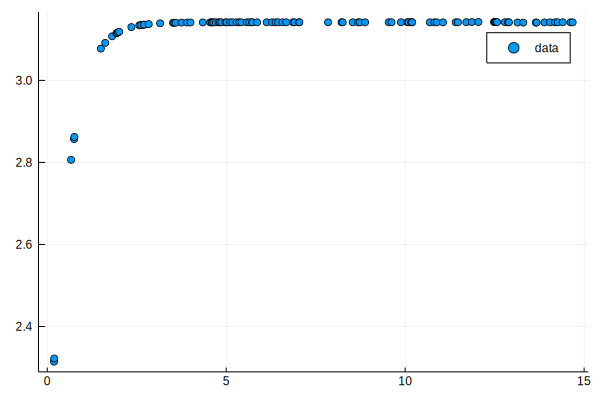

In [4]:
# initial condition  Note: 2.0f0 = 2.0e0 for type Float32 instead of Float64
u0 = Float32[2.0f0] 

# number of samples
datasize = 100

# time horizon,
tspan = (0.0f0,15f0) 

# uniformly distributed points in tspan
t = tspan[1] .+ rand(Float32, datasize)*(tspan[2]-tspan[1])

# true du/dt
f(u,p,t) = 2*sin.(u)

# underlying true ODE]
ode = ODEProblem(f, u0, tspan) 

# solution of the true ODE at time-points t
sol = solve(ode, Tsit5(), saveat=t)

# data
t, u = sol.t, Array(sol)

# plot the solution 
scatter(t, vcat(u...), label="data")

### Neural Network Model

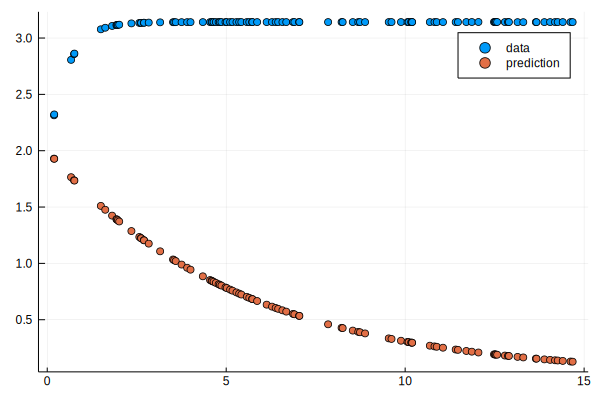

In [5]:
# neural network model
model = Chain(Dense(1,50,relu), Dense(50,100,relu), Dense(100,1))

# ODE solver for the neural network model
n_ode = NeuralODE(model, tspan, Tsit5(), saveat=t)

# prediction for given initial condition
ũ(Φ) = n_ode(u0,Φ)

# plot of the data and the (untrained) neural ODE prediction
scatter(t, vcat(u...), label="data")
scatter!(t, vcat(ũ(n_ode.p)...), label="prediction") 

### Optimization

In [6]:
# loss 
function loss(Φ) 
    pred = ũ(Φ)
    loss = sum(abs2, u .- pred)
    loss, pred
end

# callback function to observe training
cb = function (p, l, pred; doplot=false) 
  println("Loss: $l")
  if doplot
    pl = scatter(t,vcat(u...),label="data")
    scatter!(pl,t,vcat(pred...),label="prediction")
    display(plot(pl))
  end
  return false
end

# optimize with ADAM
res1 = DiffEqFlux.sciml_train(loss, n_ode.p, ADAM(0.01), cb=cb, maxiters=50)

Loss: 625.54395
Loss: 13489.551
Loss: 344.42462
Loss: 724.9684
Loss: 826.8611
Loss: 853.2359
Loss: 853.20294
Loss: 833.04767
Loss: 793.80145
Loss: 738.8588
Loss: 661.16016
Loss: 546.20874
Loss: 361.193
Loss: 81.9454
Loss: 1093.9396
Loss: 25.286581
Loss: 160.35545
Loss: 223.94301
Loss: 252.22313
Loss: 255.94482
Loss: 241.35785
Loss: 212.21385
Loss: 171.21135
Loss: 121.28661
Loss: 67.41689
Loss: 20.221872
Loss: 3.6383288
Loss: 56.55982
Loss: 83.75393
Loss: 43.24633
Loss: 9.115831
Loss: 1.8829539
Loss: 9.339423
Loss: 20.32521
Loss: 29.010626
Loss: 33.09648
Loss: 32.251102
Loss: 27.231972
Loss: 19.499207
Loss: 11.053593
Loss: 4.2311816
Loss: 1.197444
Loss: 3.0073228
Loss: 8.146535
Loss: 12.670527
Loss: 13.095778
Loss: 9.477827
Loss: 4.74668
Loss: 1.6403763
Loss: 0.992527


 * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Minimizer: [1.93e-01, -3.31e-01, -1.07e-01,  ...]
    Minimum:   9.925270e-01

 * Found with
    Algorithm:     ADAM
    Initial Point: [2.58e-01, -2.88e-01, -1.67e-01,  ...]

 * Convergence measures
    |x - x'|               = NaN ≰ 0.0e+00
    |x - x'|/|x'|          = NaN ≰ 0.0e+00
    |f(x) - f(x')|         = NaN ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = NaN ≰ 0.0e+00
    |g(x)|                 = NaN ≰ 0.0e+00

 * Work counters
    Seconds run:   110  (vs limit Inf)
    Iterations:    50
    f(x) calls:    50
    ∇f(x) calls:   50


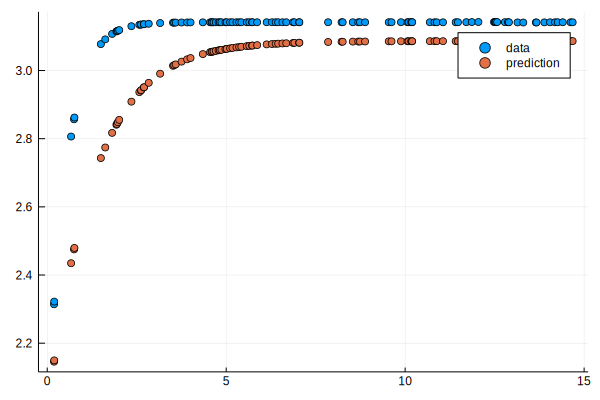

Loss: 1.7422936


In [7]:
# plot
cb(res1.minimizer, loss(res1.minimizer)...;doplot=true);

In [8]:
# optimize with LBFGS
res2 = DiffEqFlux.sciml_train(loss, res1.minimizer, LBFGS(), cb=cb)

Loss: 1.742294


┌ Warning: Instability detected. Aborting
└ @ DiffEqBase /home/julius/.julia/packages/DiffEqBase/mDFok/src/integrator_interface.jl:339
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq /home/julius/.julia/packages/OrdinaryDiffEq/8Pn99/src/initdt.jl:74
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ DiffEqBase /home/julius/.julia/packages/DiffEqBase/mDFok/src/integrator_interface.jl:333
┌ Warning: Instability detected. Aborting
└ @ DiffEqBase /home/julius/.julia/packages/DiffEqBase/mDFok/src/integrator_interface.jl:339
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq /home/julius/.julia/packages/OrdinaryDiffEq/8Pn99/src/initdt.jl:74
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ DiffEqBase /home/julius/.julia/packages/DiffEqBase/mDFok/src/integrator_interface.jl:333
┌ Warning: Instabili

Loss: 0.9873438
Loss: 0.9821956
Loss: 0.70138466
Loss: 0.44192582
Loss: 0.04171922
Loss: 0.008703225
Loss: 0.0018030512
Loss: 0.0013141428
Loss: 0.001309531
Loss: 0.0013087929
Loss: 0.0013079798
Loss: 0.0013027923
Loss: 0.0012983714
Loss: 0.0012983143
Loss: 0.0012983143


 * Status: success

 * Candidate solution
    Minimizer: [2.15e-01, -3.31e-01, -1.07e-01,  ...]
    Minimum:   1.298314e-03

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [1.93e-01, -3.31e-01, -1.07e-01,  ...]

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 9.59e-03 ≰ 1.0e-08

 * Work counters
    Seconds run:   207  (vs limit Inf)
    Iterations:    15
    f(x) calls:    181
    ∇f(x) calls:   181


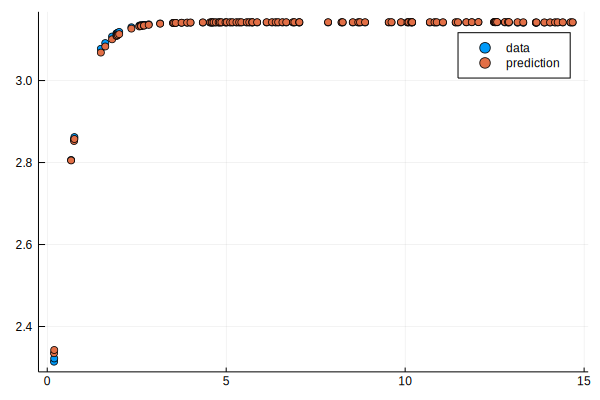

Loss: 0.0012983143


In [9]:
# plot
cb(res2.minimizer, loss(res2.minimizer)...;doplot=true);

### Extrapolate

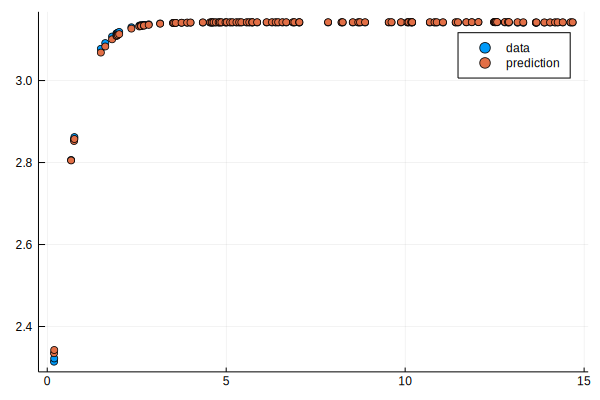

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["u0"], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 21,:min => 1,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing),"index" => (Observable{Any} with 2 listeners. Value:
11, nothing)), Set(String[]), nothing, Asset[Asset("js", "knockout", "/home/julius/.julia/packages/Knockout/IP1uR/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/home/julius/.julia/packages/Knockout/IP1uR/src/../assets/knockout_punches.js"), Asset("js", nothing, "/home/julius/.julia/packages/InteractBase/9mFwe/src/../assets/all.js"), Asset("css", nothing, "/home/julius/.julia/packages/InteractBase/9mFwe/src/../assets/style.css"), Asset("css", nothing, "/home/julius/.julia/packages/Interact/SbgIk/src/../assets/bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set(AbstractConnection[]), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007f2f3f3984f0, Task (runnable) @0x00007f2f3f3984f0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"0.0\",\"0.2\",\"0.4\",\"0.6\",\"0.8\",\"1.0\",\"1.2\",\"1.4\",\"1.6\",\"1.8\",\"2.0\",\"2.2\",\"2.4\",\"2.6\",\"2.8\",\"3.0\",\"3.2\",\"3.4\",\"3.6\",\"3.8\",\"4.0\"],\"changes\":WebIO.getval({\"name\":\"changes\",\"scope\":\"6054129022582634928\"

In [11]:
@manipulate for u0=0:0.2:4
    u0 = Float32[u0] 
    ode = ODEProblem(f, u0, tspan) 
    u = Array(solve(ode, Tsit5(), saveat=t))
    ũ = n_ode(u0,res2.minimizer)
    pl = scatter(t,vcat(u...),label="data")
    scatter!(pl,t,vcat(ũ...),label="prediction")
    display(plot(pl))
end